# Connectivity Data

**Objetive:** The following notebook gathers connectivity information from Ookla's speedtest API <br>

Author: María Reyes Retana, Consultant SCL, mariarey@iadb.org <br>
Created: April 1, 2023

In progress <br>

In [4]:
!pip install -r requirements.txt

In [ ]:
# Install needed libraries
import os
from dotenv import load_dotenv
from datetime import datetime
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load environment variables
load_dotenv('/home/ec2-user/SageMaker/.env')
sclbucket   = os.getenv("sclbucket")
scldatalake = os.getenv("scldatalake")

In [5]:
def quarter_start(year: int, q: int) -> datetime:
    """
    Returns the datetime representing the start of a quarter

    Parameters:
    year (int): The year
    q (int): The quarter

    Returns:
    datetime: The datetime object representing the start of a quarter
    """
    if not 1 <= q <= 4:
        raise ValueError("Quarter must be within [1, 2, 3, 4]")

    month = [1, 4, 7, 10]
    return datetime(year, month[q - 1], 1)


def get_tile_url(service_type: str, year: int, q: int) -> str:
    """
    Returns the URL of a tile

    Parameters:
    service_type (str): The type of the service
    year (int): The year
    q (int): The quarter

    Returns:
    str: The URL of a tile
    """
    dt = quarter_start(year, q)

    base_url = "https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance"
    url = f"{base_url}/type%3D{service_type}/year%3D{dt:%Y}/quarter%3D{q}/{dt:%Y-%m-%d}_performance_fixed_tiles.zip"
    return url 


In [6]:
def calculate_stats(data, group_fields):
    """
    Calculates weighted averages of the download and upload speeds and total tests

    Parameters:
    data (GeoDataFrame): The input GeoDataFrame
    group_fields (list): The list of fields to group by

    Returns:
    GeoDataFrame: The GeoDataFrame with the calculated stats
    """
    return (
        data.groupby(group_fields)
        .apply(
            lambda x: pd.Series(
                {"avg_d_mbps_wt": np.average(x["avg_d_mbps"], weights=x["tests"]),
                "avg_u_mbps_wt": np.average(x["avg_u_mbps"], weights=x["tests"])
                }
            )
        )
        .reset_index()
        .merge(
            data.groupby(group_fields)
            .agg(tests=("tests", "sum"))
            .reset_index(),
            on=group_fields,
        )
    )

## 1. Fixed connectivity

In [7]:
# Fixed connectivity
tile_url = get_tile_url("fixed", 2023, 1)
tile_url

'https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance/type%3Dfixed/year%3D2023/quarter%3D1/2023-01-01_performance_fixed_tiles.zip'

In [ ]:
tiles = gpd.read_file(tile_url)

In [7]:
# See if the table has the desired information
tiles.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
0,0022022300231020,87,204,578,1,1,"POLYGON ((-178.46191 70.98477, -178.45642 70.9..."
1,0022133222312322,158237,9571,170,5,2,"POLYGON ((-160.02686 70.64359, -160.02136 70.6..."
2,0022133222330012,74693,28236,164,2,1,"POLYGON ((-160.03784 70.63995, -160.03235 70.6..."
3,0022133222330023,69368,7703,251,2,1,"POLYGON ((-160.04333 70.63631, -160.03784 70.6..."
4,0022133222330030,259,260,32,1,1,"POLYGON ((-160.03784 70.63813, -160.03235 70.6..."


#### 1.1 Get boundaries 

In [8]:
# Read shapefiles for ADMIN-1 and ADMIN-2 from the datalake 
# You will need the .env for this task
lac_01 = gpd.read_file(scldatalake + "Geospatial Basemaps/Cartographic Boundary Files/LAC-26/region/level-1/lac-level-1.shp")
lac_02 = gpd.read_file(scldatalake + "Geospatial Basemaps/Cartographic Boundary Files/LAC-26/region/level-2/lac-level-2.shp")

#### 1.2 Join boundaries and tiles

In [ ]:
# Join tiles with ADMIN-1 and ADMIN-2 shapefiles
# This takes approximately 10 minutes to run. 
tiles_in_lac_01 =  gpd.sjoin(tiles, lac_01, how="inner", op= 'intersects')


In [ ]:
tiles_in_lac_02 = gpd.sjoin(tiles, lac_02, how="inner", op= 'intersects')

In [ ]:
# Convert to Mbps for easier reading
for df in [tiles_in_lac_01, tiles_in_lac_02]:
    df['avg_d_mbps'] = df['avg_d_kbps'] / 1000
    df['avg_u_mbps'] = df['avg_u_kbps'] / 1000

In [ ]:
# Calculate statistics for ADMIN-1 and ADMIN-2
region_stats_01 = calculate_stats(tiles_in_lac_01, ["ADM1_PCODE", "ADM1_EN", "ADM0_PCODE"])
region_stats_02 = calculate_stats(tiles_in_lac_02, ["ADM2_PCODE", "ADM2_EN","ADM1_PCODE", "ADM1_EN", "ADM0_PCODE"])

In [ ]:
# Save in datalake 
region_stats_01.to_csv(scldatalake + "Geospatial Basemaps/Connectivity/fixed/tiles_fixed_LAC_01.csv", index=False)
region_stats_02.to_csv(scldatalake + "Geospatial Basemaps/Connectivity/fixed/tiles_fixed_LAC_02.csv", index=False)

#### Map ADMIN-1 

In [90]:
state_data = lac_01[['ADM1_EN','geometry']].merge(region_stats_01, on ='ADM1_EN').to_crs(26916)

In [91]:
# Generate labels and ranges for plot

labels = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]

state_data['group'] = pd.cut(
    state_data.avg_d_mbps_wt, 
    (0, 25, 50, 100, 150, 200), 
    right=False, 
    labels = labels
)

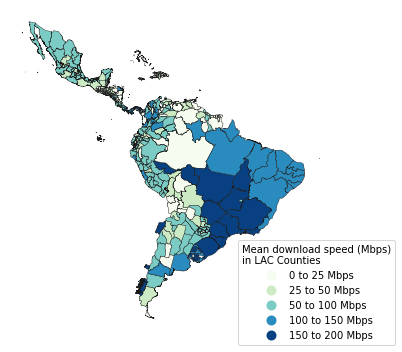

In [109]:
#plot admin level 1

fig, ax = plt.subplots(1, figsize=(9, 6))

state_data.plot(
    column="group", cmap="GnBu", linewidth=0.4, ax=ax, edgecolor="0.1", legend=True
)

ax.axis("off")

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.2, 0.3))
leg.set_title("Mean download speed (Mbps)\nin LAC Counties")

#save picture
fig.savefig("Outputs/speed_lac_state.jpg")

#### Map ADMIN-2

In [14]:
municipality_data = lac_02[['ADM2_EN','geometry']].merge(region_stats_02, on ='ADM2_EN').to_crs(26916)

In [15]:
municipality_data = lac_02[['ADM2_EN','geometry']].merge(region_stats_02, on ='ADM2_EN').to_crs(26916)

# Generate labels and ranges for plot

labels = ["0 to 10 Mbps", "10 to 30 Mbps", "30 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]

municipality_data['group'] = pd.cut(
    municipality_data.avg_d_mbps_wt, 
    (0, 10, 30 ,50, 100, 150, 200), 
    right=False, 
    labels = labels
)

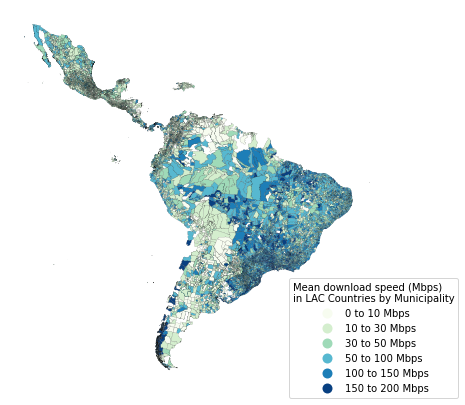

In [16]:
# Generate plot admin level-2

fig_municipality, ax = plt.subplots(1, figsize=(10, 7))

municipality_data.plot(
    column="group", cmap="GnBu", linewidth=0.1, ax=ax, edgecolor="0.1", legend=True
)

ax.axis("off")

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.2, 0.3))
leg.set_title("Mean download speed (Mbps)\nin LAC Countries by Municipality")

#save plot
fig_municipality.savefig("Outputs/speed_lac_municipality.jpg")

## Use case BRA - in progress

In [20]:
municipality_data_bra = municipality_data[municipality_data["ADM0_PCODE"]=="BRA"]

In [39]:
municipality_data_bra.to_csv("Outputs/BRA_speed.csv", index = False)

In [22]:
labels = ["0 to 10 Mbps", "10 to 30 Mbps", "30 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]

municipality_data_bra['group'] = pd.cut(
    municipality_data_bra.avg_d_mbps_wt, 
    (0, 10, 30 ,50, 100, 150, 200), 
    right=False, 
    labels = labels
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


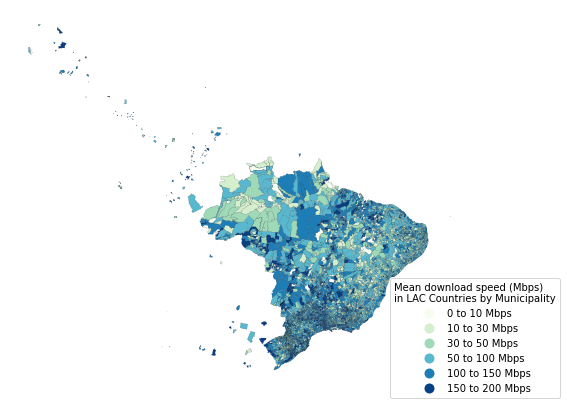

In [23]:
fig_municipality_bra, ax = plt.subplots(1, figsize=(10, 7))

municipality_data_bra.plot(
    column="group", cmap="GnBu", linewidth=0.1, ax=ax, edgecolor="0.1", legend=True
)

ax.axis("off")

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.2, 0.3))
leg.set_title("Mean download speed (Mbps)\nin LAC Countries by Municipality")

fig_municipality_bra.savefig("Outputs/speed_bra_mmunicipality.jpg")